# Introducción

Se desea saber si es posible inferir el tipo de pase tomando en cuenta las demás variables de viaje

In [84]:
import numpy as np
import pandas as pd
from utils.prepare_dataset import prepare_dataset
from utils.prepare_dataset import FeaturesEngineering

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import  OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

# Classifiers
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

### Preparación del los datos

In [29]:
# Definimos la variable parser,  para convertir las columnas 'start_time', 'end_time' a tipo datetime
parser= lambda x: pd.to_datetime(x)
df_train = pd.read_csv('data/train_set.csv', parse_dates=['start_time', 'end_time'], date_parser=parser, low_memory=False)
df_test = pd.read_csv('data/test_set.csv', parse_dates=['start_time', 'end_time'], date_parser=parser, low_memory=False)

Comenzaremos limpiando el dataset con la función prepare_dataset, estos es, cortar valores nulos y acotar las coordenadas a la región estudiada

In [3]:
df_prep = prepare_dataset(df_train)

Ahora separamos el data set:

- *X* contiene los datos para entrenar el modelo
- *y* contiene el objetivo 

In [65]:
X = df_prep.drop(['plan_duration', 'passholder_type'], axis=1)
y = df_prep['passholder_type']

Transformaremos el objetivo *y* que contiene datos categóricos

Usaremos LabelEncoder para convertir los datos categóricos en valores enteros

In [5]:
# Definimos la función LabelEncoder
labels = LabelEncoder()
# Transformamos y asignamos a una nueva variable
y_labels = labels.fit_transform(y)

Ahora vamos a separar los datos, en datos de entrenamiento y de prueba, para este caso usaremos 80% para entrenar y 20% para pruebas

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.20)

Vamos a crear un pipeline para el entrenamiento del modelo, automatizaremos la transformación de columnas.

Separamos las columnas en categoricas "cat" y numéricas "num"

- Para las columnas categoricas usaremos OneHotEncoder para transformar las categorías en columnas y tendrán los valores 0 o 1 si corresponde a un valor o no.
- Para las columnas numéricas usaremos MinMaxScaler, con esto buscamos que los datos tengan una media de 0 y desviación estandar de 1, esto optimiza las predicciones del modelo.

In [7]:
# Solo contamos con una columna categórica trip_route_category, aplicamos OneHotEncoder
cat_features = ['trip_route_category']
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# Definimos el nombre de las columnas con datos numéricos, a las que transformaremos con MinMaxScaler
num_features = ['duration', 'start_lat','start_lon', 'end_lat', 
                'end_lon', 'month', 'day', 'hour']
num_transformer = MinMaxScaler()

# Usamos ColumnTransformer para hacer las transformaciones en un solo paso
column_transform = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)

In [8]:
# Definimos el pipeline con los pasos siguientes
#    - FeaturesEngineering: Crea nuevas columnas relacionadas con la fecha, "month", "year", "hour" y corta las columnas innecesarias
#    - column_transform: Hace las transformaciones definidas en la celda anterior
#    - XGBClassifier: Sera el clasificador 

pipe = Pipeline(
    steps=[
        ('features', FeaturesEngineering()),
        ('col_trans', column_transform),
        ('classifier', XGBClassifier())
    ]
)

# Vamos a probar tres clasificadores, el modelo evaluara los tres y elegira el que tenga mejor preformance
grid_param = [
    {
        'classifier': [XGBClassifier()]
    },
    {
        'classifier': [AdaBoostClassifier()]
    },
    {
        'classifier': [GradientBoostingClassifier()]
    }
]

In [9]:
# Con GridSearchCV iteramos el pipeline con los diferentes clasificadores
# el parametro cv es de cross validation, repetiremos el proceso 3 veces por cada classificador, 
gridsearch = GridSearchCV(pipe, grid_param, cv=3, verbose=2, n_jobs=-1)
best_model= gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ....................classifier=AdaBoostClassifier(); total time= 3.4min
[CV] END ....................classifier=AdaBoostClassifier(); total time= 3.2min
[CV] END ....................classifier=AdaBoostClassifier(); total time= 3.2min
[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_s

Ahora que entrenamos el modelo obtenemos el mejor estimador, en esta ocación el modelo de XGBoost obtuvo un mejor rendimiento

In [10]:
best_model.best_estimator_

Pipeline(steps=[('features', FeaturesEngineering()),
                ('col_trans',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['duration', 'start_lat',
                                                   'start_lon', 'end_lat',
                                                   'end_lon', 'month', 'day',
                                                   'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['trip_route_category'])])),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               cols...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, ...))])

Realizamos el calculo de precisión del modelo

In [89]:
# Copiamos los datos de prueba, para mantener intactos los definidos previamente
X_to_pipe, y_to_pipe = X_test.copy(), y_test.copy()
best_model.score(X_to_pipe, y_to_pipe)

0.7180177913293172

Podemos ver que las predicciones no son muy buenas pero no son del todo malas, 71% significa que de cada 10 datos acierta en 7

### Metricas del modelo

Ahora usemos las herramientas de Scikit-Learn para calcular las metricas de nuestro modelo

In [110]:
predict = best_model.predict(X_test.copy())

print('Accuracy: ', accuracy_score(y_test, predict))
print('Presición: ', precision_score(y_test, predict, average='weighted'))

Accuracy:  0.7180177913293172
Presición:  0.7150196895211156


Accuracy y precision score cuentan el numero de clasificaciones correctas y se dividen entre el numero de clases existentes por cada etiqueta

In [76]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.77      0.11      0.19      6598
           1       0.82      0.02      0.04      2313
           2       0.73      0.92      0.82     77745
           3       0.65      0.05      0.09      7878
           4       1.00      0.45      0.62        11
           5       0.68      0.60      0.64     40577

    accuracy                           0.72    135122
   macro avg       0.78      0.36      0.40    135122
weighted avg       0.72      0.72      0.68    135122



In [114]:
# Veamos las clases para guiarnos al analizar los resultados
labels.classes_

array(['Annual Pass', 'Flex Pass', 'Monthly Pass', 'One Day Pass',
       'Testing', 'Walk-up'], dtype=object)

In [116]:
confusion_matrix(y_test, predict)

array([[  702,     1,  5409,    13,     0,   473],
       [    0,    46,  1998,     0,     0,   269],
       [  144,     6, 71681,    58,     0,  5856],
       [   16,     0,  2794,   401,     0,  4667],
       [    0,     0,     1,     1,     5,     4],
       [   49,     3, 16196,   144,     0, 24185]])

Analizando la matriz de confisión es claro ver que las clases más complejas de clasificar son para *"Monthly Pass"* y *Walk-up*, pero es normal ya que son las clases con mas precencia en el dataset.

En contraste para las clases *"Flex Pass"* y "*Testing*" el modelo tuvo menos errores al momento de clasificarlos

Por lo que podemos deducir que los usuarios de estos pases tiene un comportamiento muy definido por lo que es más fácil clasificarlos, mientras que para las clases más frecuentes el comportamiento es más variado y pueden compartir ciertas similitudes entre las clases lo que hace más díficil la clasificaión.

### Analisis de features importances

Veamos cómo el modelo definio que tan importantes era cada característica en la clasificación

In [10]:
from joblib import load
from sklearn.pipeline import Pipeline
from pydantic import BaseModel
from pandas import DataFrame
import os
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt

model_path = os.environ.get('MODEL_PATH', 'model/model.pkl')
best_model = []
with open(model_path, 'rb') as model_file:
    while True:
        try:
            best_model.append(load(BytesIO(model_file.read())))
        except EOFError:
            break
# best_model = pickle.load(open('model/model.pkl', 'rb'))

[]


In [2]:
best_model.best_estimator_['classifier'].feature_importances_

NameError: name 'best_model' is not defined

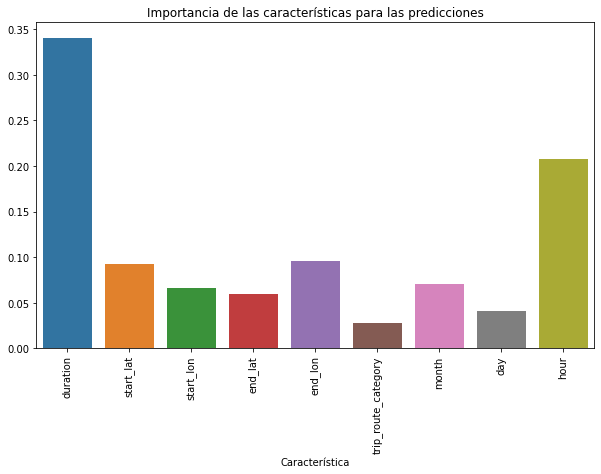

<Figure size 432x288 with 0 Axes>

In [109]:
plt.figure(figsize=(10, 6))
sns.barplot(x=X_to_pipe.columns, y=best_model.best_estimator_['classifier'].feature_importances_[:9])
plt.title('Importancia de las características para las predicciones')
plt.xticks(rotation=90)
plt.xlabel('Característica')

plt.savefig('images/analytics_feature_importances')

Notamos que la característica más importante es la duración del viaje seguida de la hora en que inicia el viaje, con estos datos podríamos segmentar al tipo de usuario.

Para concluir podríamos definir que el modelo es bueno, se podría mejorar dado la diferencia en el uso de los pases con más información de los pases menos comunes tal vez podríamos generar inferencias más precisas, también si tuvieramos datos de los usuarios como edad o genero podrías ser características que mejoren las predicciones.

### Aplicamos el modelo al dataset de **Test**

In [32]:
y_to_predict = df_test.copy()
predictions = best_model.predict(y_to_predict)


In [37]:
pretiction_labels = pd.DataFrame(labels.inverse_transform(predictions), columns=['passholder_type'])

In [41]:
submission = pd.concat([df_test['trip_id'], pretiction_labels], axis=1)
submission.to_csv('data/submission.csv')

### Save the model

In [117]:
import pickle

# Abrimos el archivo para modificar
file = open('model/model.pkl', 'wb')

# Escribimos el modelo
pickle.dump(best_model, file)